In [3]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from keras.models import Model

# from keras.models import Input, Model

from scipy import sparse
import tensorflow as tf
import matplotlib.pyplot as plt


In [4]:
texts = pd.read_csv('TextNLP.csv')

texts = [x for x in texts['text']]
print(len(texts))
print(texts)


12
['The future king is the prince', 'Daughter is the princess ', 'Son is the prince', 'Only a man can be a king ', 'Only a woman can be a queen', 'The princess will be a queen', 'Queen and king rule the realm', 'The prince is a strong man', 'The princess is a beautiful woman ', 'The royal family is the king and queen and their children', 'Prince is only a boy now', 'A boy will be a man']


In [5]:
def text_preprocessing(
        text: list,
        punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
        stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but', 'this', 'were', 'with', 'of', 'also',
                    'on', '.', 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as']
) -> list:
    """
    A method to preproces text
    """
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x != '']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text



In [6]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []
for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)
    # print (text)

    # Appending to the all text list
    all_text += text

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text):
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

word_lists

[['future', 'king'],
 ['future', 'prince'],
 ['king', 'prince'],
 ['king', 'future'],
 ['prince', 'king'],
 ['prince', 'future'],
 ['daughter', 'princess'],
 ['princess', 'daughter'],
 ['son', 'prince'],
 ['prince', 'son'],
 ['only', 'man'],
 ['only', 'can'],
 ['man', 'can'],
 ['man', 'only'],
 ['man', 'king'],
 ['can', 'king'],
 ['can', 'man'],
 ['can', 'only'],
 ['king', 'can'],
 ['king', 'man'],
 ['only', 'woman'],
 ['only', 'can'],
 ['woman', 'can'],
 ['woman', 'only'],
 ['woman', 'queen'],
 ['can', 'queen'],
 ['can', 'woman'],
 ['can', 'only'],
 ['queen', 'can'],
 ['queen', 'woman'],
 ['princess', 'queen'],
 ['queen', 'princess'],
 ['queen', 'king'],
 ['queen', 'rule'],
 ['king', 'rule'],
 ['king', 'queen'],
 ['king', 'realm'],
 ['rule', 'realm'],
 ['rule', 'king'],
 ['rule', 'queen'],
 ['realm', 'rule'],
 ['realm', 'king'],
 ['prince', 'strong'],
 ['prince', 'man'],
 ['strong', 'man'],
 ['strong', 'prince'],
 ['man', 'strong'],
 ['man', 'prince'],
 ['princess', 'beautiful'],
 ['p

In [7]:
def create_unique_word_dict(text: list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict

In [8]:
unique_word_dict = create_unique_word_dict(all_text)
# Defining the number of features (unique words)
n_words = len(unique_word_dict)
print(unique_word_dict)

{'beautiful': 0, 'boy': 1, 'can': 2, 'children': 3, 'daughter': 4, 'family': 5, 'future': 6, 'king': 7, 'man': 8, 'now': 9, 'only': 10, 'prince': 11, 'princess': 12, 'queen': 13, 'realm': 14, 'royal': 15, 'rule': 16, 'son': 17, 'strong': 18, 'their': 19, 'woman': 20}


In [9]:
# Getting all the unique words
words = list(unique_word_dict.keys())
print(words)


['beautiful', 'boy', 'can', 'children', 'daughter', 'family', 'future', 'king', 'man', 'now', 'only', 'prince', 'princess', 'queen', 'realm', 'royal', 'rule', 'son', 'strong', 'their', 'woman']


In [10]:
# Creating the X and Y matrices using one hot encoding
print(n_words)
X = []
Y = []
for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    print(word_list)
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])
    # print (word_list)
    print(word_list[0], main_word_index)
    print(word_list[1], context_word_index)

    # Creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

21


84it [00:00, 3271.60it/s]

['future', 'king']
future 6
king 7
['future', 'prince']
future 6
prince 11
['king', 'prince']
king 7
prince 11
['king', 'future']
king 7
future 6
['prince', 'king']
prince 11
king 7
['prince', 'future']
prince 11
future 6
['daughter', 'princess']
daughter 4
princess 12
['princess', 'daughter']
princess 12
daughter 4
['son', 'prince']
son 17
prince 11
['prince', 'son']
prince 11
son 17
['only', 'man']
only 10
man 8
['only', 'can']
only 10
can 2
['man', 'can']
man 8
can 2
['man', 'only']
man 8
only 10
['man', 'king']
man 8
king 7
['can', 'king']
can 2
king 7
['can', 'man']
can 2
man 8
['can', 'only']
can 2
only 10
['king', 'can']
king 7
can 2
['king', 'man']
king 7
man 8
['only', 'woman']
only 10
woman 20
['only', 'can']
only 10
can 2
['woman', 'can']
woman 20
can 2
['woman', 'only']
woman 20
only 10
['woman', 'queen']
woman 20
queen 13
['can', 'queen']
can 2
queen 13
['can', 'woman']
can 2
woman 20
['can', 'only']
can 2
only 10
['queen', 'can']
queen 13
can 2
['queen', 'woman']
queen 13

In [11]:
# Converting the matrices into a sparse format because the vast majority of the data are 0s
print(X)
print(Y)


[array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]),

In [12]:
# X= sparse.csr_matrix(X)
# Y = sparse.csr_matrix(Y)
# print (X)
# print(X[0, :].toarray())
# print (X.todense())
# a = X.todense()
# print (a[0])
XX = tf.convert_to_tensor(X, dtype=tf.float32)
YY = tf.convert_to_tensor(Y, dtype=tf.float32)
print(XX.shape)
print(YY.shape)


(84, 21)
(84, 21)


In [13]:
def CreateModel():
    # Defining the size of the embedding
    embed_size = 2
    # Defining the neural network

    # inp = Input(shape=(X.shape[1],))
    inp = Input(shape=XX.shape[1])  # 21
    x = Dense(units=embed_size, activation='linear')(inp)
    # x = Dense(units=21, activation='softmax')(x)
    x = Dense(units=YY.shape[1], activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    return model


In [14]:
model = CreateModel()
# Optimizing the network weights
model.fit(
    x=XX,
    y=YY,
    batch_size=10,
    epochs=2000
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 2)                 44        
                                                                 
 dense_1 (Dense)             (None, 21)                63        
                                                                 
Total params: 107
Trainable params: 107
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
9/9 [==============================] - 1s 2ms/step - loss: 3.0397
Epoch 2/2000
9/9 [==============================] - 0s 2ms/step - loss: 3.0347
Epoch 3/2000
9/9 [==============================] - 0s 2ms/step - loss: 3.0304
Epoch 4/2000
9/9 [==============================] - 0s 2ms/step - loss: 3.0266
Epoch 5/200

In [15]:
# The input layer

weights = model.get_weights()[0] #21*2
print(weights.shape)
print(weights[1][1])
print(weights)

# weights = model.get_weights()[2]
# print (weights)

(21, 2)
0.6642316
[[-3.5396729   0.3680828 ]
 [ 2.8769157   0.6642316 ]
 [-0.05676182  0.19717084]
 [-1.8421873  -1.5458685 ]
 [-4.7752614   3.4068096 ]
 [-0.23349884 -5.482745  ]
 [ 2.0137215  -1.0634458 ]
 [-0.12899868 -0.20313556]
 [ 0.45753393  1.0107901 ]
 [ 0.5725195   1.3716829 ]
 [-0.03113905  0.8923429 ]
 [ 1.1690564   1.1679566 ]
 [-4.1108637  -1.9679691 ]
 [-0.7279791  -0.08128088]
 [ 0.28133014 -1.3953246 ]
 [ 3.7258873  -5.6323295 ]
 [-0.28817993 -4.545854  ]
 [ 5.924641   -1.406258  ]
 [ 4.5355334  -0.26007175]
 [-0.92365575 -4.7033763 ]
 [-1.0790225   0.47505406]]


In [16]:
#get the weight for each unique word
embedding_dict = {}
for word in words: #to pick the a row of weight of two values for each unique word since weights = 21*2
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
    })

print(embedding_dict)


{'beautiful': array([-3.5396729,  0.3680828], dtype=float32), 'boy': array([2.8769157, 0.6642316], dtype=float32), 'can': array([-0.05676182,  0.19717084], dtype=float32), 'children': array([-1.8421873, -1.5458685], dtype=float32), 'daughter': array([-4.7752614,  3.4068096], dtype=float32), 'family': array([-0.23349884, -5.482745  ], dtype=float32), 'future': array([ 2.0137215, -1.0634458], dtype=float32), 'king': array([-0.12899868, -0.20313556], dtype=float32), 'man': array([0.45753393, 1.0107901 ], dtype=float32), 'now': array([0.5725195, 1.3716829], dtype=float32), 'only': array([-0.03113905,  0.8923429 ], dtype=float32), 'prince': array([1.1690564, 1.1679566], dtype=float32), 'princess': array([-4.1108637, -1.9679691], dtype=float32), 'queen': array([-0.7279791 , -0.08128088], dtype=float32), 'realm': array([ 0.28133014, -1.3953246 ], dtype=float32), 'royal': array([ 3.7258873, -5.6323295], dtype=float32), 'rule': array([-0.28817993, -4.545854  ], dtype=float32), 'son': array([ 5.

0  >>  beautiful
1  >>  boy
2  >>  can
3  >>  children
4  >>  daughter
5  >>  family
6  >>  future
7  >>  king
8  >>  man
9  >>  now
10  >>  only
11  >>  prince
12  >>  princess
13  >>  queen
14  >>  realm
15  >>  royal
16  >>  rule
17  >>  son
18  >>  strong
19  >>  their
20  >>  woman


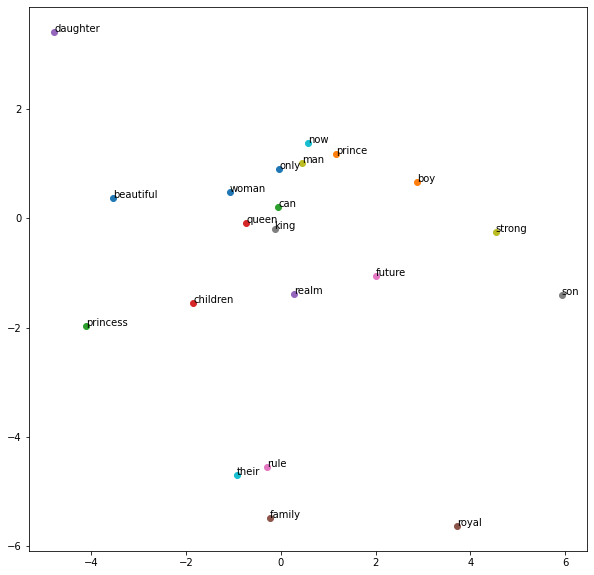

In [17]:
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    i = i + 1

In [18]:
# The input layer
weights = model.get_weights()[0]
# weights[: , 0] = 0


0  >>  beautiful
1  >>  boy
2  >>  can
3  >>  children
4  >>  daughter
5  >>  family
6  >>  future
7  >>  king
8  >>  man
9  >>  now
10  >>  only
11  >>  prince
12  >>  princess
13  >>  queen
14  >>  realm
15  >>  royal
16  >>  rule
17  >>  son
18  >>  strong
19  >>  their
20  >>  woman


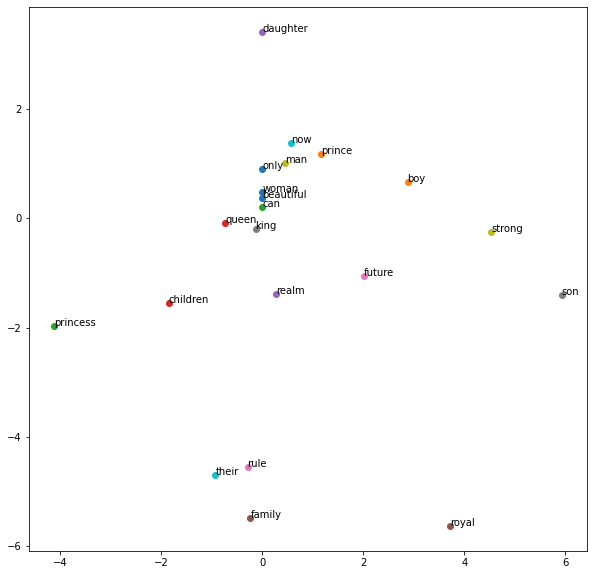

In [19]:
plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict.keys()):
    print(i, ' >> ', word)
    # coord = embedding_dict.get(word)
    coord = embedding_dict.get(word)
    if weights[i][0] < 0 and weights[i][1] > 0:
        plt.scatter(0, weights[i][1])
        plt.annotate(word, (0, weights[i][1]))
    else:
        plt.scatter(weights[i][0], weights[i][1])
        plt.annotate(word, (weights[i][0], weights[i][1]))

        #plt.xlim(-0.5, 0.5)
        #plt.ylim(-0.5, 0.5)
        #plt.show()
    i = i + 1

In [20]:
# -*- coding: utf-8 -*-
"""WordEmbedding.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1r9K8Kt1Wf8wALjfxiKHySCnrqUA4PFfA
"""



# Deep learning:
# from tensorflow.python.keras.models import Input







'WordEmbedding.ipynb\n\nAutomatically generated by Colaboratory.\n\nOriginal file is located at\n    https://colab.research.google.com/drive/1r9K8Kt1Wf8wALjfxiKHySCnrqUA4PFfA\n'